# Figure 5
data is stored in ../../data

# setup and load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_violins_w_percent,
    plot_motif_boxplot_stripplot,
    format_small_plot,
)

## extra functions

In [3]:
def plot_violinplot_with_percentages(df, y_column, color="tab:red", ax=None):
    # Calculate percentages
    percentages = (
        df.groupby(y_column)
        .apply(lambda x: (x["ln_r_data"] > -5.45).mean() * 100)
        .round(2)
    )

    # Sort y_column values by percentage
    sorted_y_values = percentages.sort_values(ascending=False).index

    if ax is None:
        fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
    else:
        fig = ax.figure

    sns.violinplot(
        data=df,
        x="ln_r_data",
        y=y_column,
        density_norm="width",
        color=color,
        linewidth=0.5,
        order=sorted_y_values,
        ax=ax,
    )
    ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)

    # Add percentage labels
    for i, y_value in enumerate(sorted_y_values):
        ax.text(-9.7, i, f"{percentages[y_value]:.2f}%", va="center", ha="right")

    ax.set_xlim(-12.5, -3)
    ax.set_xticks([-10, -8, -6, -4, -2])
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    y_label = ""
    if y_column == "p3_res":
        y_label = "3' Nucleotide"
    elif y_column == "p5_res":
        y_label = "5' Nucleotide"
    elif y_column == "r_stack":
        y_label = "Nucleotide Stack"
    ax.set_ylabel(y_label, labelpad=2)
    format_small_plot(ax)

    return fig, ax

In [4]:
# Function to create scatter plot with linear regression for distance vs reactivity analysis
def create_scatter_plot_w_regression(df, ax, x_col, y_col, color_by_pdb_res=False):
    # Prepare the data
    X = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Compute R-squared
    r2 = r2_score(y, model.predict(X))

    if color_by_pdb_res:
        scatter = ax.scatter(X.flatten(), y, s=6, c=df["pdb_res"], cmap="viridis")
        plt.colorbar(scatter, ax=ax, label="PDB Residue")
    else:
        ax.scatter(X.flatten(), y, s=6)

    # Add regression line
    ax.plot(X, model.predict(X), color="black", linewidth=1)

    return r2

In [5]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "Pyrimidine"
    elif row["both_purine"]:
        return "Purine"
    else:
        return "Mixed"

### load data

In [6]:
DATA_PATH = "../../data/"

In [7]:
df_constructs = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df_constructs_nomod = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

df = df.query("r_data_outlier == False").copy()

df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")


df_corr = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_reactivity_correlation.csv"
)
df_corr_data = pd.read_csv(f"{DATA_PATH}/pdb-features/non_canonical_atom_distances.csv")
df_ratio_corr = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_reactivity_ratio_correlation.csv"
)
df_ratio_corr_data = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_with_ratio.csv"
)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/lg/b_1r07zd7174kpbyfysdr7p0dxd870/T/ipykernel_85892/2136339409.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)


# Plotting 

## Figure 5a

0.5068710179916276


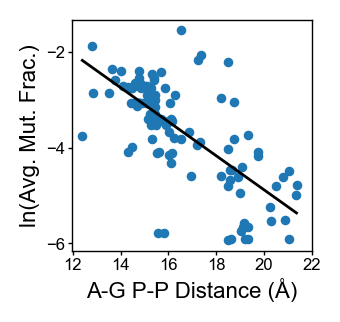

In [15]:
df_corr_data_ag = df_corr_data.query(
    'pair == "A-G" and atom1 == "P" and atom2 == "P"'
).copy()
df_corr_data_ag.sort_values(by="distance", ascending=False, inplace=True)
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_corr_data_ag, ax, "distance", "ln_r_data_mean")

ax.set_xlabel("A-G P-P Distance (Å)", labelpad=2)
ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
ax.set_xticks([12, 14, 16, 18, 20, 22])
format_small_plot(ax)
print(r2)
plt.savefig("pngs/figure_5b.png", dpi=600)

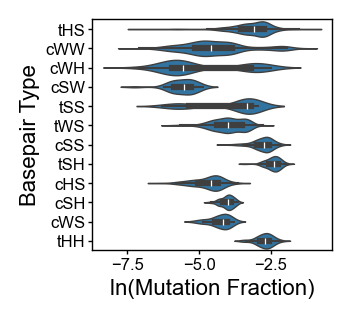

In [17]:
df_pdb_ag = df_pdb.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and pdb_r_pair == 'A-G' and no_of_interactions == 1"
).copy()
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)
sns.violinplot(
    data=df_pdb_ag,
    y="pdb_r_bp_type",
    x="ln_r_data",
    density_norm="width",
    ax=ax,
    linewidth=0.5,
)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_ylabel("Basepair Type", labelpad=2)
format_small_plot(ax)
plt.savefig("pngs/figure_5c.png", dpi=600)

0.5954623192812827
35


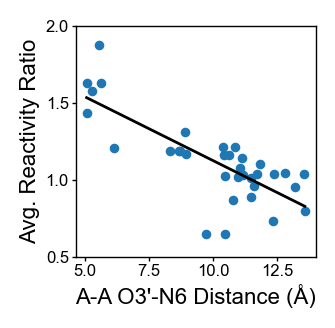

In [35]:
df_ratio_corr_data_aa = df_ratio_corr_data.query(
    'pair == "A-A" and atom1 == "O3\'" and atom2 == "N6"'
).copy()
df_ratio_corr_data_aa.sort_values(by="distance", ascending=False, inplace=True)
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_ratio_corr_data_aa, ax, "distance", "ratio")

ax.set_xlabel("A-A O3'-N6 Distance (Å)", labelpad=2)
ax.set_ylabel("Avg. Reactivity Ratio", labelpad=2)
ax.set_xticks([5, 7.5, 10, 12.5])
ax.set_yticks([0.5, 1, 1.5, 2])
format_small_plot(ax)
print(r2)
print(len(df_ratio_corr_data_aa))
plt.savefig("pngs/figure_5e.png", dpi=600)

In [26]:
df_pdb_aa = df_pdb.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and pdb_r_pair == 'A-A'"
).copy()
new_rows = []
count = 0
for i, group in df_pdb_aa.groupby(["m_sequence", "constructs", "m_pos", "pdb_name"]):
    if len(group) == 2:
        sorted_group = group.sort_values(by="r_data", ascending=True)
        new_row = sorted_group.iloc[1].copy()
        new_row["r_data_ratio"] = (
            sorted_group.iloc[1]["r_data"] / sorted_group.iloc[0]["r_data"]
        )
        new_row["r_data_other"] = sorted_group.iloc[0]["r_data"]
        new_row["r_stack_other"] = sorted_group.iloc[0]["r_stack"]
        new_row["p5_res_other"] = sorted_group.iloc[0]["p5_res"]
        new_row["p3_res_other"] = sorted_group.iloc[0]["p3_res"]
        new_rows.append(new_row)
    else:
        count += 1
df_pdb_aa_combined = pd.DataFrame(new_rows)

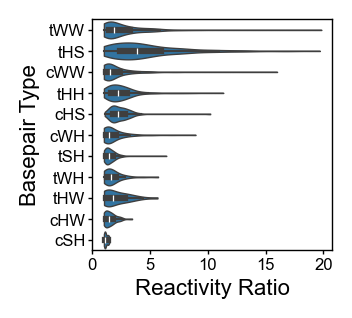

In [34]:
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)
ax = sns.violinplot(
    y="pdb_r_bp_type",
    x="r_data_ratio",
    data=df_pdb_aa_combined.sort_values(by="r_data_ratio", ascending=False),
    linewidth=0.5,
    density_norm="width",
    cut=0,
)
format_small_plot(ax)
ax.set_xlabel("Reactivity Ratio", labelpad=2)
ax.set_ylabel("Basepair Type", labelpad=2)
ax.set_xticks([0, 5, 10, 15, 20])
plt.savefig("pngs/figure_5f.png", dpi=600)

0.5139449403790018


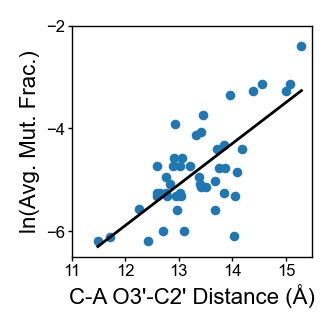

In [40]:
df_corr_data_ca = df_corr_data.query(
    'pair == "C-A" and atom1 == "O3\'" and atom2 == "C2\'"'
).copy()
df_corr_data_ca.sort_values(by="distance", ascending=False, inplace=True)
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_corr_data_ca, ax, "distance", "ln_r_data_mean")

ax.set_xlabel("C-A O3'-C2' Distance (Å)", labelpad=2)
ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
ax.set_xticks([11, 12, 13, 14, 15])
ax.set_yticks([-6, -4, -2])
format_small_plot(ax)
print(r2)
plt.savefig("pngs/figure_5h.png", dpi=600)

0.6532282028839684


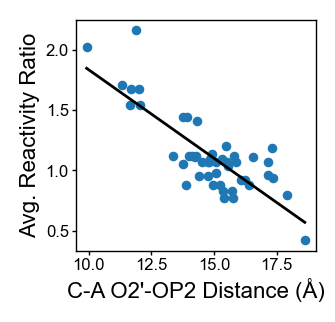

In [43]:
df_ratio_corr_data_ac = df_ratio_corr_data.query(
    'pair == "C-A" and atom1 == "O2\'" and atom2 == "OP2"'
).copy()
df_ratio_corr_data_ac.sort_values(by="distance", ascending=False, inplace=True)
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_ratio_corr_data_ac, ax, "distance", "ratio")

ax.set_xlabel("C-A O2'-OP2 Distance (Å)", labelpad=2)
ax.set_ylabel("Avg. Reactivity Ratio", labelpad=2)
ax.set_xticks([10, 12.5, 15, 17.5])
ax.set_yticks([0.5, 1, 1.5, 2])
format_small_plot(ax)
print(r2)
plt.savefig("pngs/figure_5i.png", dpi=600)

0.6365635588287752


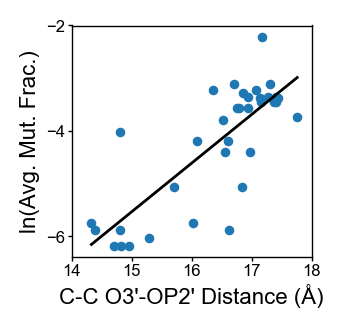

In [47]:
df_corr_data_cc = df_corr_data.query(
    'pair == "C-C" and atom1 == "O3\'" and atom2 == "OP2"'
).copy()
df_corr_data_cc.sort_values(by="distance", ascending=False, inplace=True)
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_corr_data_cc, ax, "distance", "ln_r_data_mean")

ax.set_xlabel("C-C O3'-OP2' Distance (Å)", labelpad=2)
ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
ax.set_xticks([14, 15, 16, 17, 18])
ax.set_yticks([-6, -4, -2])
format_small_plot(ax)
print(r2)
plt.savefig("pngs/figure_5k.png", dpi=600)

0.6905075526528316


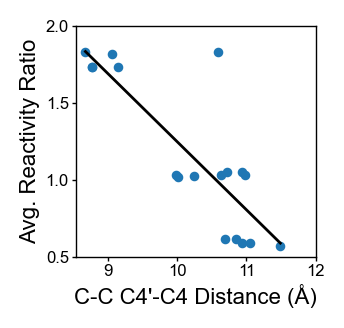

In [51]:
df_ratio_corr_data_cc = df_ratio_corr_data.query(
    'pair == "C-C" and atom1 == "C4\'" and atom2 == "C4"'
).copy()
df_ratio_corr_data_cc.sort_values(by="distance", ascending=False, inplace=True)
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_ratio_corr_data_cc, ax, "distance", "ratio")

ax.set_xlabel("C-C C4'-C4 Distance (Å)", labelpad=2)
ax.set_ylabel("Avg. Reactivity Ratio", labelpad=2)
ax.set_xticks([9, 10, 11, 12])
ax.set_yticks([0.5, 1, 1.5, 2])
format_small_plot(ax)
print(r2)
plt.savefig("pngs/figure_5l.png", dpi=600)